<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/RR_Data_Science_Assignment_D_Sirtioglu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RaboResearch Data Science Assignment
###Submitted by: Doruk Sirtioglu
###Date: 05-02-2021

##The problem

We have a binary classification problem in this assignment. We will create the labels (positive equals buy and negative equals no investment) by answering the question below: \

If you buy some McDonald’s stock (MCD) today, are you guaranteed to make at least 10% profit in the coming 10 working days?

###Assumptions: 

1. On the day of purchase, you buy with the highest price. On the day of sale, you sell with the lowest price of the day.
2. If at least 10% profit is guaranteed within 10 working days, the label should be positive.
3. You can sell any day after purchase (e.g. next working day) but not day of purchase and a maximum of 10 working days after purchase is the last possible day for selling (for labeling 15th June 2020, the first possible selling day is 16th June 2020 and the last possible selling day is 29th June 2020).
4. Given your constraints by working in a bank, you are only allowed to purchase once
and sell once within the 10 working days after purchase. \

The model should be predictive and only use data up to the date of purchase to train your model.

###Abstract

In this project, we use McD ticker data together with additional related datasets to predict the performance of the McD stocks in the coming 10 days. We first explore the existing and merged data and create synthetic variables to be used in the model. Following the paper 'Stock market one-day ahead movement prediction using disparate data sources' by Weng, Ahmed and Megahed (2017), we select the model variables and trained SVM, DT and ANN models. We then evaluate their performance by the metrics: AUC, Accuracy, Precision, Recall, F1-Score and MCC. We observe the best performance with the SVM model and use it to predict the target. 

##Import data and libraries

In [28]:
#Install yfinance library and download features.xlsx
!pip install yfinance -q

!wget -O features.zip 'https://docs.google.com/uc?export=download&id=1BawB1Zm43rmk7HMftFWnwizN-cyd7nnD' -q --show-progress !unzip features.zip

!wget -O label_raw.csv 'https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg' -q --show-progress
!ls

features.zip            [ <=>                ]   2.03M  --.-KB/s    in 0.01s   
label_raw.csv       100%[===================>] 937.80K  --.-KB/s    in 0.01s   
features.zip  label_raw.csv  sample_data


In [29]:
#Import libraries

import yfinance as yf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pandas.tseries.offsets import MonthEnd
import sqlite3

!pip install sklearn -q

from sklearn.model_selection import train_test_split

#SVM
from sklearn.svm import SVC

#DT
from sklearn.tree import DecisionTreeClassifier

#ANN
from sklearn.neural_network import MLPClassifier

#Metrics
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from tabulate import tabulate

In [30]:
dataset_for_label = None

In [31]:
#Import McD historic ticker data

url_mcd = 'https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg'

dataset_for_label = pd.read_csv(url_mcd)
dataset_for_label.Date = dataset_for_label.Date.astype('datetime64') 

#Obsolete:
#msft = yf.Ticker("MCD")
#dataset_for_label = msft.history(period="max") 

dataset_for_label.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
13723,2021-01-11,215.089996,216.119995,213.119995,214.229996,2545900,0.0,0.0
13724,2021-01-12,213.690002,214.330002,210.940002,211.600006,2952000,0.0,0.0
13725,2021-01-13,210.910004,213.130005,210.899994,212.089996,2069800,0.0,0.0
13726,2021-01-14,212.100006,212.669998,208.000000,208.500000,3666700,0.0,0.0
13727,2021-01-15,207.970001,210.699997,207.419998,209.910004,3592900,0.0,0.0


In [32]:
#Define 'Date' as index

dataset_for_label['Date'] = pd.to_datetime(dataset_for_label['Date'])
dataset_for_label.set_index('Date', inplace=True)

dataset_for_label.insert(0,'Date','')
dataset_for_label['Date'] = dataset_for_label.index
dataset_for_label.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2021-01-11,2021-01-11,215.089996,216.119995,213.119995,214.229996,2545900,0.0,0.0
2021-01-12,2021-01-12,213.690002,214.330002,210.940002,211.600006,2952000,0.0,0.0
2021-01-13,2021-01-13,210.910004,213.130005,210.899994,212.089996,2069800,0.0,0.0
2021-01-14,2021-01-14,212.100006,212.669998,208.000000,208.500000,3666700,0.0,0.0
2021-01-15,2021-01-15,207.970001,210.699997,207.419998,209.910004,3592900,0.0,0.0


In [90]:
#Import NYSE historic data

Ticker = yf.Ticker("^NYA")
NYSE_Dataset = Ticker.history(period="Max")
NYSE_Dataset.insert(0,'Date','')
NYSE_Dataset["Date"] = NYSE_Dataset.index
NYSE_Dataset.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2021-06-01,2021-06-01,16555.660156,16718.669922,16555.660156,16643.320312,4122960000,0,0
2021-06-02,2021-06-02,16643.320312,16691.960938,16620.550781,16673.960938,4860930000,0,0
2021-06-03,2021-06-03,16673.960938,16673.960938,16530.199219,16632.339844,4579450000,0,0
2021-06-04,2021-06-04,16632.339844,16718.009766,16632.339844,16708.740234,3487070000,0,0
2021-06-07,2021-06-07,16708.699219,16725.546875,16669.904297,16690.449219,0,0,0


##Exploring the data and adding synthetic variables

In [34]:
#Row and column count

dataset_for_label.idxmax

<bound method DataFrame.idxmax of                  Date        Open        High  ...   Volume  Dividends  Stock Splits
Date                                           ...                                  
1966-07-05 1966-07-05    0.000000    0.004074  ...   388800        0.0           0.0
1966-07-06 1966-07-06    0.000000    0.004227  ...   687200        0.0           0.0
1966-07-07 1966-07-07    0.000000    0.004335  ...  1853600        0.0           0.0
1966-07-08 1966-07-08    0.000000    0.004120  ...  1238400        0.0           0.0
1966-07-11 1966-07-11    0.000000    0.004227  ...   655200        0.0           0.0
...               ...         ...         ...  ...      ...        ...           ...
2021-01-11 2021-01-11  215.089996  216.119995  ...  2545900        0.0           0.0
2021-01-12 2021-01-12  213.690002  214.330002  ...  2952000        0.0           0.0
2021-01-13 2021-01-13  210.910004  213.130005  ...  2069800        0.0           0.0
2021-01-14 2021-01-14  212.1000

In [35]:
#Descriptive statistics

dataset_for_label.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,13728.000000,13728.000000,13728.000000,13728.000000,1.372800e+04,13728.000000,13728.000000
mean,29.242837,29.482376,29.008394,29.250153,4.361553e+06,0.004144,0.001129
std,48.212416,48.572002,47.849269,48.213585,3.172883e+06,0.056896,0.044541
min,0.000000,0.002328,0.002267,0.002298,4.800000e+04,0.000000,0.000000
25%,0.025791,0.026079,0.025408,0.025788,2.380350e+06,0.000000,0.000000
50%,7.604995,7.667455,7.532961,7.591115,3.710300e+06,0.000000,0.000000
75%,32.429903,32.745175,32.019403,32.428267,5.539825e+06,0.000000,0.000000
max,229.048626,230.539771,227.796069,228.283173,8.698130e+07,1.500000,2.000000


In [36]:
#Check whether there are any NaNs

dataset_for_label.isnull().values.any()

False

In [37]:
#Define 'Date' as datetime

#dataset_for_label.Date = dataset_for_label.Date.astype('datetime64[ns]') 
dataset_for_label.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

Our target is to detect the days which have at least 10% increase in the following ten days. Hence we create ten new columns that checks for such case in any of the ten days. Then we control whether any of these ten columns have a positive class with the new column called 'CheckAnyFw10d' where 1 is 'yes' and 0 is 'no'. We will refer to the 'yes' cases as "positive dates" hereafter.

In [38]:
#Create binary variables to check if there has been 10% increase in any of the coming 10 days

for x in range(1,11):
  exec('dataset_for_label["CheckFw' + str(x) + 'd"] = np.where((dataset_for_label.Low.shift(-' + str(x) + ') / dataset_for_label.High) >= 1.1, 1, 0)')
  ;

dataset_for_label["CheckAnyFw10d"] = np.where(dataset_for_label.filter(like='CheckFw').sum(axis = 1, skipna = True) > 0, 1, 0) 

###Defining the observation scope

In [39]:
#Compare the number of positive days to the non-positive days for the entire dataset

dataset_for_label["CheckAnyFw10d"].value_counts()

0    13224
1      504
Name: CheckAnyFw10d, dtype: int64

In their study, Weng et. al. (2017) use a three year scope to train their model. Although scoping down would result having less data to work with, doing so helps giving more weight to the recent data, which in turn helps capturing the 'essence of today'. Given the very low frequency of positive cases, we extend the scope to 21 years, starting from 01-01-2000. This enables including a significant amount of positive cases between 2000 and 2004.

In [40]:
#Define the observation scope

Today = dataset_for_label.index.max()

min_date = '2000-01-01'
max_date = Today

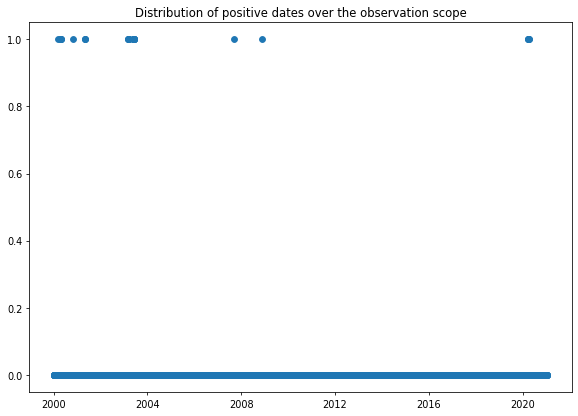

In [41]:
#Visualize the distribution of positive dates throught the observation scope

plt.scatter(dataset_for_label[dataset_for_label['Date'] >= min_date]['Date'], dataset_for_label[dataset_for_label['Date'] >= min_date]['CheckAnyFw10d'])
plt.title('Distribution of positive dates over the observation scope')

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (10, 5)

In [42]:
#Compare the number of positive days to the non-positive days within the observation scope

dataset_for_label[(dataset_for_label['Date'] >= min_date) & (dataset_for_label['Date'] <= max_date)]["CheckAnyFw10d"].value_counts()

0    5263
1      31
Name: CheckAnyFw10d, dtype: int64

We create a copy of the original dataset to include data only from the scoped dates.

In [43]:
#Define a copy of the dataset with the date scope

dataset_scoped = dataset_for_label[dataset_for_label['Date'] >= min_date].copy()

#Set date as index

dataset_scoped.set_index('Date', inplace=True)
dataset_scoped.insert(0,'Date','')
dataset_scoped['Date'] = dataset_scoped.index
dataset_scoped.tail(5)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CheckFw1d,CheckFw2d,CheckFw3d,CheckFw4d,CheckFw5d,CheckFw6d,CheckFw7d,CheckFw8d,CheckFw9d,CheckFw10d,CheckAnyFw10d
Date,,,,,,,,,,,,,,,,,,,
2021-01-11,2021-01-11,215.089996,216.119995,213.119995,214.229996,2545900,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
2021-01-12,2021-01-12,213.690002,214.330002,210.940002,211.600006,2952000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
2021-01-13,2021-01-13,210.910004,213.130005,210.899994,212.089996,2069800,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
2021-01-14,2021-01-14,212.100006,212.669998,208.000000,208.500000,3666700,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
2021-01-15,2021-01-15,207.970001,210.699997,207.419998,209.910004,3592900,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0


Furthermore, we try to observe if there is a relationship between the price changes and the traded volume. To do so, we visualize the normalized variables. Normalization facilitates easier readability of the graph.

In [72]:
#Normalize variables

#Volume:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset_scoped['Volume'].values.reshape(-1,1))
dataset_scoped['Volume_Norm'] = scaled_data


#Low:
scaled_data = scaler.fit_transform(dataset_scoped['Low'].values.reshape(-1,1))
dataset_scoped['Low_Norm'] = scaled_data

In [75]:
dataset_scoped.describe

<bound method NDFrame.describe of                  Date        Open  ...  Volume_Norm  Low_Norm
Date                               ...                       
2000-01-03 2000-01-03   23.567775  ...     0.041356  0.070843
2000-01-04 2000-01-04   23.198957  ...     0.037821  0.069338
2000-01-05 2000-01-05   22.903892  ...     0.049622  0.070509
2000-01-06 2000-01-06   23.088316  ...     0.044714  0.070174
2000-01-07 2000-01-07   23.014554  ...     0.048379  0.070676
...               ...         ...  ...          ...       ...
2021-01-11 2021-01-11  215.089996  ...     0.018400  0.933422
2021-01-12 2021-01-12  213.690002  ...     0.023121  0.923533
2021-01-13 2021-01-13  210.910004  ...     0.012865  0.923351
2021-01-14 2021-01-14  212.100006  ...     0.031429  0.910195
2021-01-15 2021-01-15  207.970001  ...     0.030571  0.907564

[5294 rows x 21 columns]>

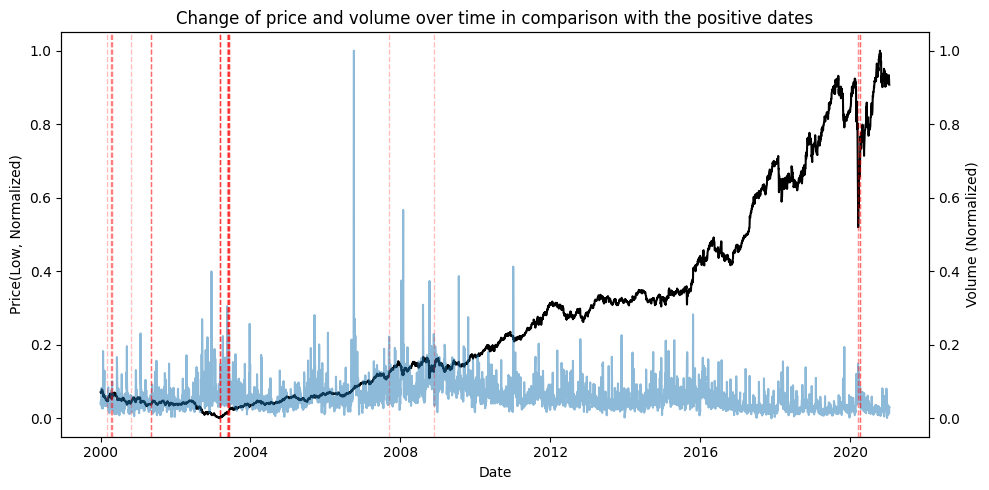

In [82]:
#Plot the price change compared to volume for the observation period 

fig, ax1 = plt.subplots()

color = 'tab:black'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price(Low, Normalized)')
ax1.plot(dataset_scoped['Low_Norm'], color = 'black')
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Volume (Normalized)') 
ax2.plot(dataset_scoped['Volume_Norm'], alpha = 0.5)
ax2.tick_params(axis='y')

#Determine the positive dates

positive_dates = dataset_scoped[(dataset_scoped['CheckAnyFw10d'] == 1)]["Date"]


#Mark the all the dates where a 10% increase is observed in the following 10 days

for x in positive_dates:
  exec('plt.axvline(pd.to_datetime("'  + str(x) + '"), color=\'red\', linestyle = \'--\', lw = 1, alpha = 0.25)')
  ;

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['figure.dpi'] = 100

plt.title('Change of price and volume over time in comparison with the positive dates')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show>

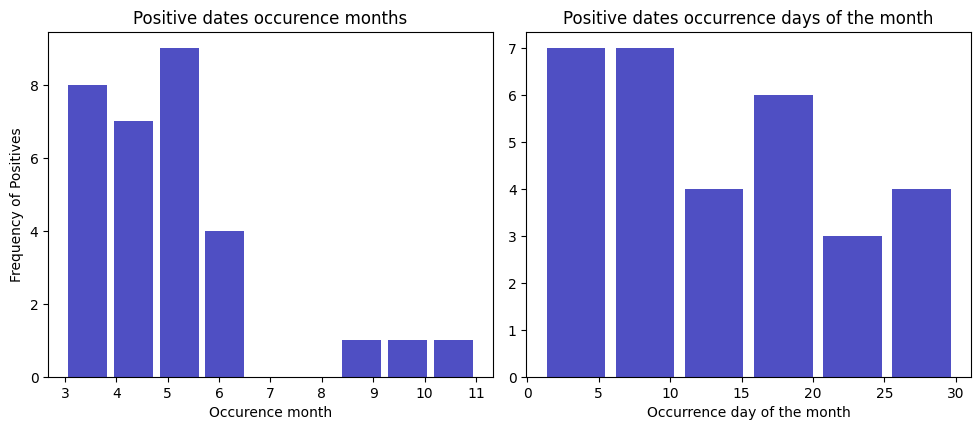

In [83]:
#Look for seasonality patterns

f, axarr = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8))

##Months

positive_months = positive_dates.dt.month

plt.subplot(2, 2, 1)
plt.hist(positive_months, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Occurence month')
plt.ylabel('Frequency of Positives')
plt.title('Positive dates occurence months')

##Days

positive_days = positive_dates.dt.day

plt.subplot(2, 2, 2)
plt.hist(positive_days, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Occurrence day of the month')
#plt.ylabel('Frequency of Positives')
plt.title('Positive dates occurrence days of the month')

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (10, 5)

plt.tight_layout()
plt.show

In [84]:
#Define a control variable to indicate the first half of the year

dataset_scoped['YearFirstHalf'] = np.where(dataset_scoped['Date'].dt.month <= 6, 1, 0)
dataset_scoped['YearFirstHalf'].tail(10)

Date
2021-01-04    1
2021-01-05    1
2021-01-06    1
2021-01-07    1
2021-01-08    1
2021-01-11    1
2021-01-12    1
2021-01-13    1
2021-01-14    1
2021-01-15    1
Name: YearFirstHalf, dtype: int64

No observable pattern exists in the distribution of positive dates over the days of the month. We observe, on the other hand, that it is more likely to have a positive dates in the first half of the year. 
However, in our preliminary analysis, the 'YearFirstHalf' variable performed poorly in predicting the positive cases. Hence we exclude it in our end model.

In [85]:
#Create a past 10 days indicator

x = 1 

while x <= 10:
  exec('dataset_scoped["CheckPast' + str(x) + 'd"] = np.where((dataset_scoped.Close / dataset_scoped.Close.shift(' + str(x) + ')) <= 0.9, 1, 0)')
  x = x + 1
  ;

dataset_scoped["CheckAnyPast10d"] = np.where(dataset_scoped.filter(like='CheckPast').sum(axis = 1, skipna = True) > 0, 1, 0) 

<function matplotlib.pyplot.show>

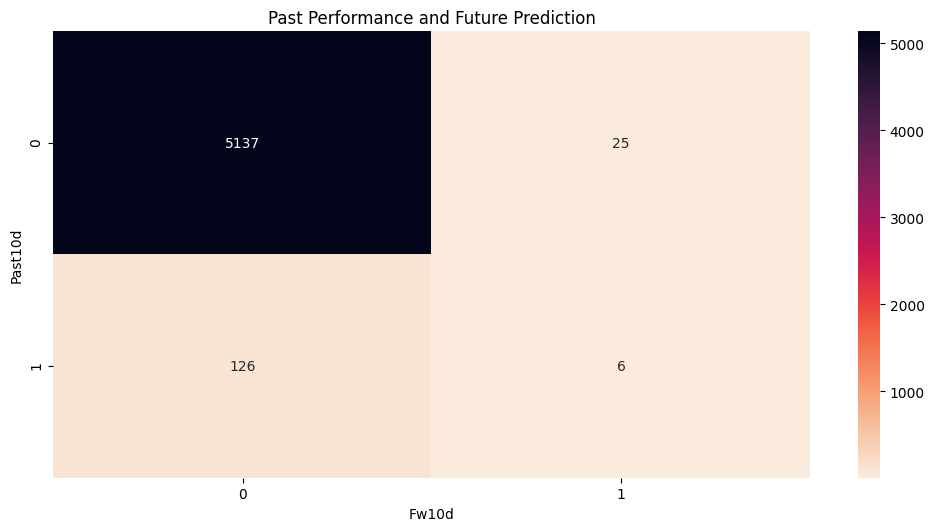

In [86]:
comparison_matrix = metrics.confusion_matrix(dataset_scoped["CheckAnyPast10d"], dataset_scoped["CheckAnyFw10d"])

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(comparison_matrix), annot=True, cmap='rocket_r' ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Past Performance and Future Prediction', y=1.1)
plt.ylabel('Past10d')
plt.xlabel('Fw10d')

plt.rcParams['figure.dpi'] = 70
plt.rcParams["figure.figsize"] = (10, 7)
plt.show

In [87]:
#Sythetic binary variables (created on the original dataset to avoid NaN values at the min_date)

dataset_for_label['ClosePrevDay'] = dataset_for_label.Close.shift(1)
dataset_for_label['VolumePrevDay'] = dataset_for_label.Volume.shift(1)

#Insert the columns to the scoped dataset
dataset_scoped['ClosePrevDay'] = dataset_for_label[dataset_for_label['Date'] >= min_date]['ClosePrevDay']
dataset_scoped['VolumePrevDay'] = dataset_for_label[dataset_for_label['Date'] >= min_date]['VolumePrevDay']

In [91]:
#Create a past 10 days indicator for NYSE

x = 1

while x <= 10:
  exec('NYSE_Dataset["CheckPast' + str(x) + 'd"] = np.where((NYSE_Dataset.Close / NYSE_Dataset.Close.shift(' + str(x) + ')) <= 0.9, 1, 0)')
  x = x + 1
;

NYSE_Dataset['CheckAnyPast10d'] = np.where(NYSE_Dataset.filter(like='CheckPast').sum(axis = 1, skipna = True) > 0, 1, 0)

##Merge data to be used in the models

In [92]:
#Join the McD dataset with NYSE_Merged dataset
dataset_merged = dataset_scoped.join(NYSE_Dataset, how='left', rsuffix='_NYSE')
dataset_merged.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CheckFw1d,CheckFw2d,CheckFw3d,CheckFw4d,CheckFw5d,CheckFw6d,CheckFw7d,CheckFw8d,CheckFw9d,CheckFw10d,CheckAnyFw10d,Volume_Norm,Low_Norm,YearFirstHalf,CheckPast1d,CheckPast2d,CheckPast3d,CheckPast4d,CheckPast5d,CheckPast6d,CheckPast7d,CheckPast8d,CheckPast9d,CheckPast10d,CheckAnyPast10d,ClosePrevDay,VolumePrevDay,Date_NYSE,Open_NYSE,High_NYSE,Low_NYSE,Close_NYSE,Volume_NYSE,Dividends_NYSE,Stock Splits_NYSE,CheckPast1d_NYSE,CheckPast2d_NYSE,CheckPast3d_NYSE,CheckPast4d_NYSE,CheckPast5d_NYSE,CheckPast6d_NYSE,CheckPast7d_NYSE,CheckPast8d_NYSE,CheckPast9d_NYSE,CheckPast10d_NYSE,CheckAnyPast10d_NYSE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,23.567775,23.641540,22.977659,23.383364,4520600,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.041356,0.070843,1,0,0,0,0,0,0,0,0,0,0,0,23.789074,1444400.0,2000-01-03,6762.109863,6762.109863,6762.109863,6762.109863,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,2000-01-04,23.198957,23.346486,22.645722,22.903898,4216500,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.037821,0.069338,1,0,0,0,0,0,0,0,0,0,0,0,23.383364,4520600.0,2000-01-04,6543.759766,6543.759766,6543.759766,6543.759766,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,2000-01-05,22.903892,23.825949,22.903892,23.272715,5231600,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.049622,0.070509,1,0,0,0,0,0,0,0,0,0,0,0,22.903898,4216500.0,2000-01-05,6567.029785,6567.029785,6567.029785,6567.029785,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-06,2000-01-06,23.088316,23.235845,22.830139,22.940786,4809400,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.044714,0.070174,1,0,0,0,0,0,0,0,0,0,0,0,23.272715,5231600.0,2000-01-06,6635.439941,6635.439941,6635.439941,6635.439941,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-07,2000-01-07,23.014554,23.604671,22.940790,23.530907,5124700,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.048379,0.070676,1,0,0,0,0,0,0,0,0,0,0,0,22.940786,4809400.0,2000-01-07,6792.669922,6792.669922,6792.669922,6792.669922,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Build the predictive model

In [93]:
#Define train and test sets

Today        = dataset_merged.index.max()
Input_vars   = ['CheckAnyPast10d', 'ClosePrevDay', 'Open', 'CheckAnyPast10d_NYSE'] 
target       = 'CheckAnyFw10d'
x            = dataset_merged[(dataset_merged["Date"] < Today)][Input_vars] #Exclude today from the training set
y            = dataset_merged[(dataset_merged["Date"] < Today)]['CheckAnyFw10d']
x_validation = dataset_merged[(dataset_merged["Date"] == Today)][Input_vars] #Define today at the validation set

#Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

###Support Vector Machine

In [94]:
#Predict using SVM

#Train model

SVM = SVC(kernel='rbf',
            class_weight='balanced', #adjust weights inversely proportional to class frequency
            random_state=42,
            probability=True)
 
SVM.fit(x_train, y_train)

#Predict on testing set

y_pred_svm = SVM.predict(x_test)

#### Performance Evaluation

<function matplotlib.pyplot.show>

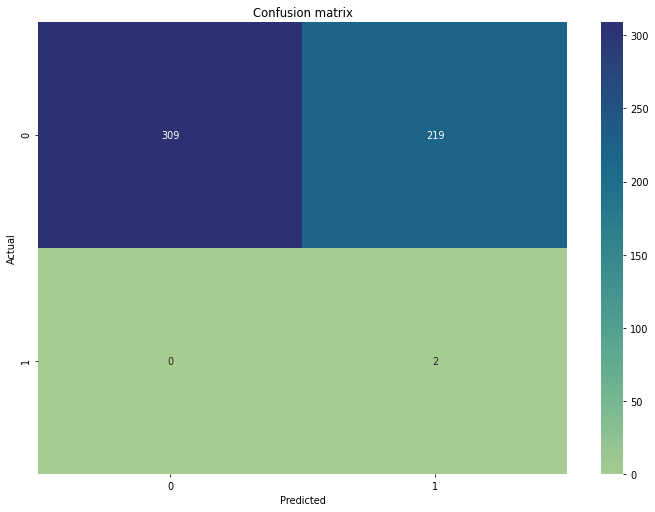

In [95]:
#Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_svm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Create heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='crest', fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (10, 7)
plt.show

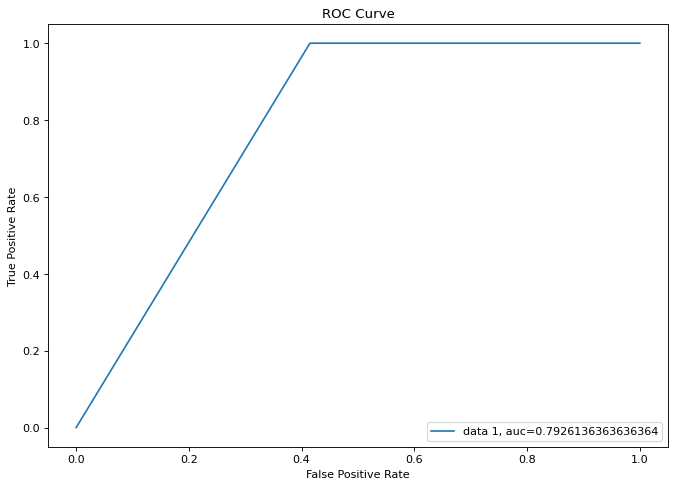

In [97]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_svm)
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_svm))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
#SVM Evaluation metrics

#RMSE
rmse_svm = metrics.RMSE(y_test, y_pred_svm)

#AUC
auc_svm

#Accuracy
Accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)

#Precision
Precision_svm = metrics.precision_score(y_test, y_pred_svm)

#Recall
Recall_svm = metrics.recall_score(y_test, y_pred_svm)

#F-measure
F1_score_svm = metrics.f1_score(y_test, y_pred_svm)

#MCC
MCC_svm = metrics.matthews_corrcoef(y_test, y_pred_svm)

AttributeError: ignored

### Decision Tree Model

In [ ]:
#Build the model

DT = DecisionTreeClassifier(class_weight = None, criterion='gini', 
min_impurity_split=1e-07, min_samples_leaf=1,
min_samples_split=2, min_weight_fraction_leaf=0.0,
presort=False, random_state=None, splitter='best')

DT.fit(x_train, y_train)

y_pred_dt = DT.predict(x_test)

#### Performance Evaluation

In [ ]:
#Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_dt)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Create heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='crest', fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (10, 7)
plt.show

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_dt)
auc_dt = metrics.roc_auc_score(y_test, y_pred_dt)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_dt))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#DT Evaluation metrics

#AUC
auc_dt

#Accuracy
Accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt) #, normalize=False)

#Precision
Precision_dt = metrics.precision_score(y_test, y_pred_dt)

#Recall
Recall_dt = metrics.recall_score(y_test, y_pred_dt)

#F-measure
F1_score_dt = metrics.f1_score(y_test, y_pred_dt)

#MCC
MCC_dt = metrics.matthews_corrcoef(y_test, y_pred_dt)

## Artificial Neural Network Model



In [ ]:
#Build the model

ANN = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=42)

ANN.fit(x_train, y_train)

y_pred_ann = ANN.predict(x_test)


#### Performance Evaluation

In [ ]:
#Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_ann)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='crest', fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (10, 7)
plt.show

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_ann)
auc_ann = metrics.roc_auc_score(y_test, y_pred_ann)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_ann))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#ANN Evaluation metrics

#RMSE
rmse

#AUC
auc_ann

#Accuracy
Accuracy_ann = metrics.accuracy_score(y_test, y_pred_ann)

#Precision
Precision_ann = metrics.precision_score(y_test, y_pred_ann)

#Recall
Recall_ann = metrics.recall_score(y_test, y_pred_ann)

#F-measure
F1_score_ann = metrics.f1_score(y_test, y_pred_ann)

#MCC
MCC_ann = metrics.matthews_corrcoef(y_test, y_pred_ann)

In [ ]:
#Performance evaluation of the three models

print(tabulate([['SVM', auc_svm, Accuracy_svm, Precision_svm, Recall_svm, F1_score_svm, MCC_svm],
                ['DT', auc_dt, Accuracy_dt, Precision_dt, Recall_dt, F1_score_dt, MCC_dt],
                ['ANN', auc_ann, Accuracy_ann, Precision_ann, Recall_ann, F1_score_ann, MCC_ann]],                
               headers=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']))

##Results

Out of the three models, Support Vector Machine model had the highest performance scores in predicting on the test data. This is also in line with Weng et. al (2017). Therefore we use the SVM model to answer the assignment question whether to buy the McD stock today (or in the latest day available in the dataset).

In [ ]:
#Run the prediction for the latest date available:

Buy_today = SVM.predict(x_validation)
Result = "Positive, buy today!" if Buy_today == 1 else "Negative, do not buy today!"
print ("Result: " + str(Result))